# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotData(data):
        plt.plot(np.linspace(3800,len(data)-1+3800,len(data)), data.tolist(),linewidth=1)
        
def plotFilters(filters):
    filters = filters.flatten()[1:-1].reshape(-1,2)
    for x in filters:
        plt.axvspan(x[0]+3800, x[1]+3800, alpha=0.5, facecolor='grey')
        
def sizeMap(inputSize):
    IN = inputSize
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    C5 = (S4-50)+1
    S6 = int(C5/2)
    return IN, C1, S2, C3, S4, C5, S6 


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list
    
    

## AGN Emission Lines (3000 - 8000 A)
https://ned.ipac.caltech.edu/level5/Netzer/Netzer2_1.html

```
CIII λ977
OVI λ1035
Lα
NV λ1240
OI λ1304
CII λ1336
SiIV,OIV] λ1400
NIV] λ1486
CIV λ1549 
HeII λ1640
OIII] λ1663
NIII] λ1750
CIII] λ1909
FeII λ(2200-2800)  
MgII λ2798
[NeV] λ3426
[OII] λ3727
[NeIII] λ3869
HeII λ4686
Hβ λ4861
[OIII] λ4959,5007
FeII λ(4500-5400) 
HeI λ5876
[FeVII] λ6087
[OI] λ6300
[FeX] λ6374
Hα λ6563
[NII] λ6583
[SII] λ6716,6731
CaII λ8498-8662
[SIII] λ9069,9532
```

The emission line spectrum of active galactic nuclei and the unifying scheme
https://link.springer.com/article/10.1007%2Fs001590000006

```
(Broad permmited lines)
HI, HeI λλ5876,6678,7065
He II λ4686
Fe II visible domain

(narrow line)
[Fe VII] λ6087
[Fe X] λ6375
[Fe XI] λ7892
```

add more balmer lines
```
Hγ λ4340
H-δ λ4102
```


FeII Lines, Table I in
https://arxiv.org/pdf/1004.2212.pdf


without FeII:

lines = [3869,4102,4340,4686,4861,4959,5007,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]


with Fe II:

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]

In [3]:
def _filters(lines, width, Ha_width=280, Hb_width=120, Hg_width=60):
    boundery_0 = np.array([[line-width/2,line+width/2] for line in lines if line<4338]).flatten()
    boundery_Hg = np.array([4340-Hg_width/2,4340+Hg_width/2]).flatten()
    boundery_1 = np.array([[line-width/2,line+width/2] for line in lines if (line>4342 and line<4860)]).flatten()
    boundery_Hb = np.array([4861-Hb_width/2,4861+Hb_width/2]).flatten()
    boundery_2 = np.array([[line-width/2,line+width/2] for line in lines if (line>4862 and line<6560)]).flatten()
    boundery_Ha = np.array([6563-Ha_width/2,6563+Ha_width/2]).flatten()
    boundery_3 = np.array([[line-width/2,line+width/2] for line in lines if line>6566]).flatten()
    boundery = np.concatenate((boundery_0, boundery_Hg, boundery_1,boundery_Hb,boundery_2,boundery_Ha,boundery_3),axis=0).reshape(-1,2)
    # 1st filter, filter the right boundery, ignore those right right bouderies smaller than the previous one
    index = [1]
    while len(index):
        signs = np.sign(boundery[1:]-boundery[:-1])
        index = np.argwhere(signs==-1)[:,0]+1
        if len(index)>0:
            boundery = np.delete(boundery,index,0)
    #print(boundery)
    # 2nd filter, compare right boundery and next left boundery, if smaller, merge two intervals.
    boundery = boundery.flatten()
    filters = []
    filters.append(boundery[0]) 
    i = 1
    while i< (len(boundery)-1):
        if boundery[i]<boundery[i+1]:
            filters.append(boundery[i])
            i=i+1
        else: 
            i=i+2
    filters.append(boundery[-1])
    return np.array(filters).reshape(-1,2)

def _filterTensor(tensor, lines, width, begin=3800, end=7500):
    filters = _filters(lines, width).flatten()
    filters = np.insert(filters,0,begin)
    filters = np.append(filters,end)
    filters = filters.reshape(-1,2)
    filters = (filters-3800).astype(int)
    if len(tensor.size()) == 1:
        return torch.cat([tensor[f[0]:f[1]] for f in filters],dim=1), filters
    else:
        return torch.cat([tensor[:,f[0]:f[1]] for f in filters],dim=1), filters

## read  data

In [4]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_train_1 = read_data('type1-pixels-3800-7500-redshifted-normalized-train.csv', delimiter=',')
sy19_feature_test_1 = read_data('type1-pixels-3800-7500-redshifted-normalized-test.csv', delimiter=',')
sy19_feature_train_2 = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_test_2 = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [5]:
# read sy19 with noise   
sy19_noise_feature_train = []
for file in glob.glob('sy19-pixels*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature_train = np.concatenate((sy19_noise_feature_train, file_feature), axis=0)

sy19_noise_feature_test = []
for file in glob.glob('sy19-test*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature_test = np.concatenate((sy19_noise_feature_test, file_feature), axis=0)

reading: sy19-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.4.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.5.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.6.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.7.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.8.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.9.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.4.csv


In [6]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
sy19_feature_train = np.concatenate((sy19_feature_train_1, sy19_feature_train_2, sy19_noise_feature_train), axis=0)
sy19_feature_test = np.concatenate((sy19_feature_test_1, sy19_feature_test_2), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature_train = torch.Tensor(sy19_feature_train).view(-1,7500-3800+1)
sy19_feature_test = torch.Tensor(sy19_feature_test).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

In [7]:
# filter wavelength
lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

sy19_feature_train_filtered, filters = _filterTensor(sy19_feature_train, lines, width, begin=3800, end=7500)
sy19_feature_test_filtered, filters = _filterTensor(sy19_feature_test, lines, width, begin=3800, end=7500)
sy20_feature_filtered, filters = _filterTensor(sy20_feature, lines, width, begin=3800, end=7500)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Density')

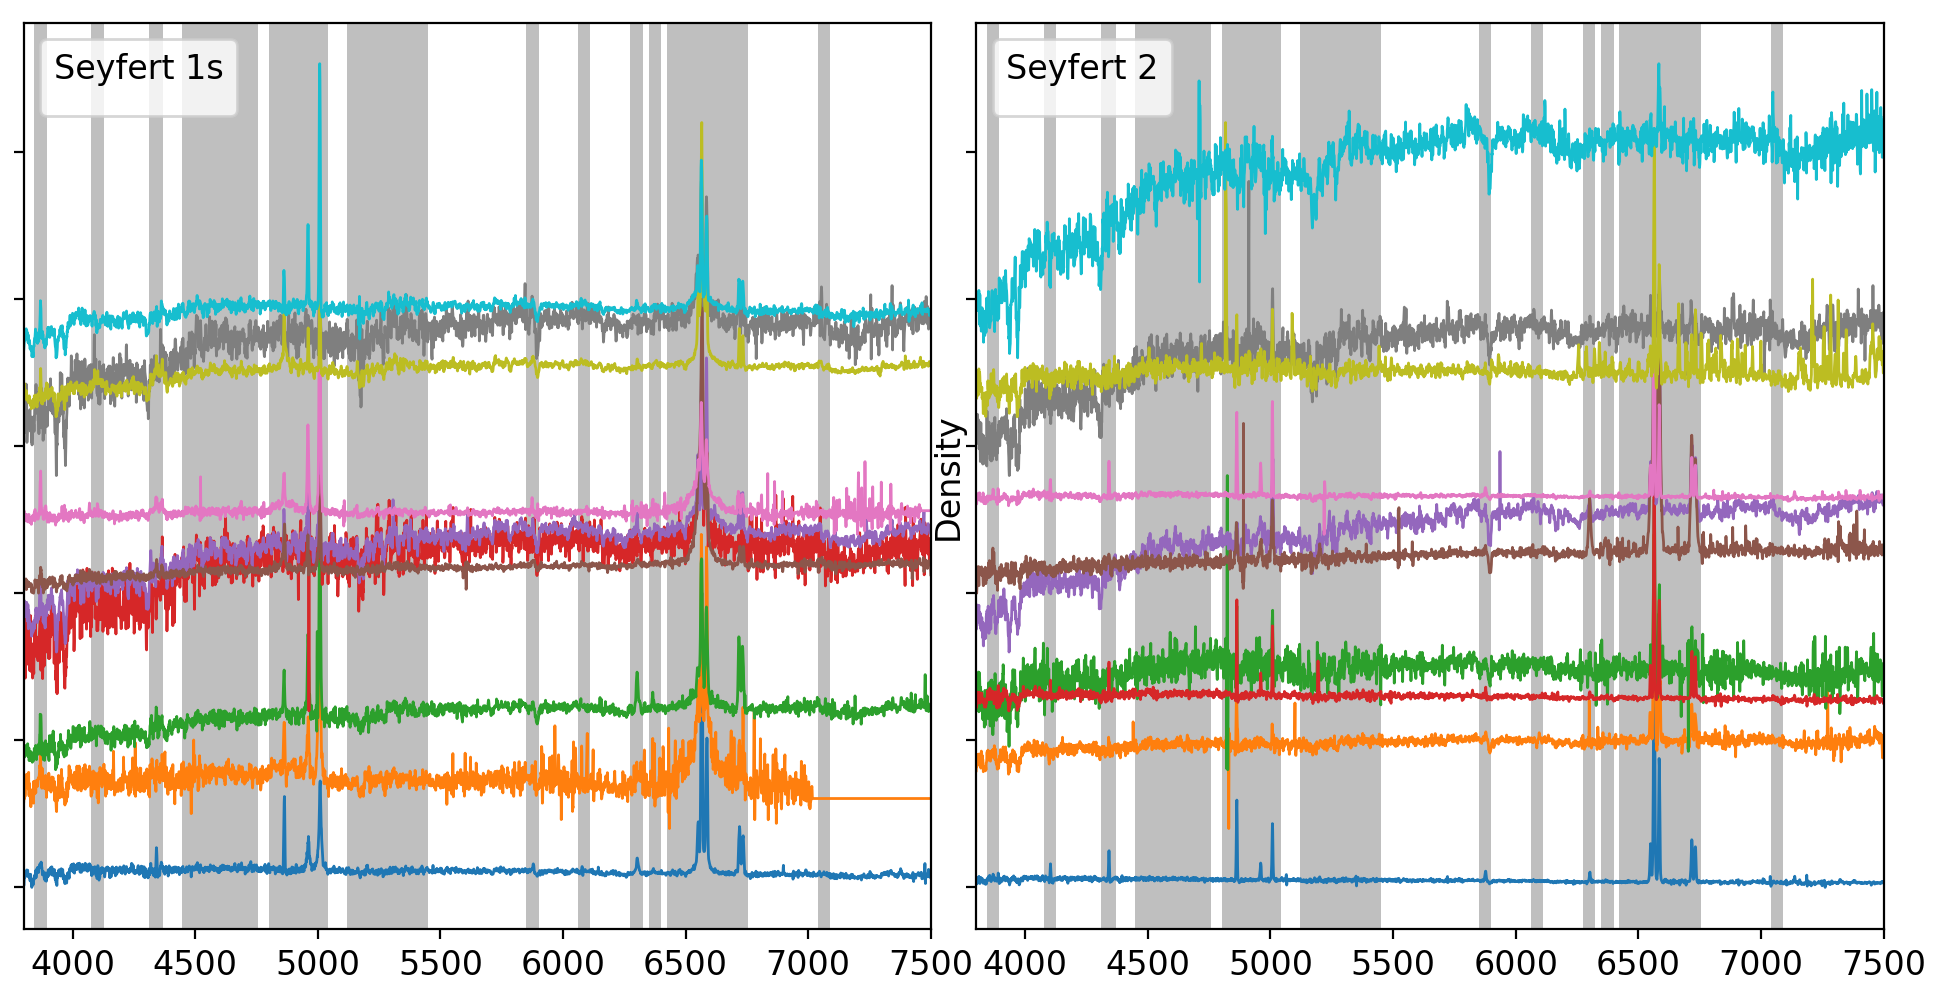

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace = 0.05)
for i in range(10):
    plt.sca(axs[0])
    axs[0].set_yticklabels([])
    plotData(sy19_feature_test[i]+i/5)
plotFilters(filters)
plt.legend(title='Seyfert 1s',loc=2)
for i in range(10):
    plt.sca(axs[1])
    axs[1].set_yticklabels([])
    plotData(sy20_feature[i]+i/5)
plotFilters(filters)
plt.legend(title='Seyfert 2',loc=2)


plt.xlim(3800,7500)

plt.ylabel('Density')

In [9]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label_train = torch.ones(sy19_feature_train.size(0),dtype=torch.long)
sy19_label_test = torch.ones(sy19_feature_test.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

# create indices
sy19_indice_train = torch.linspace(0,len(sy19_feature_train)-1,len(sy19_feature_train)).int()
sy19_indice_test = torch.linspace(0,len(sy19_feature_test)-1,len(sy19_feature_test)).int()
sy20_indice = torch.linspace(0,len(sy20_feature)-1,len(sy20_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
sy19_dataset_train = TensorDataset(sy19_indice_train,sy19_feature_train_filtered,sy19_label_train)
sy19_dataset_test = TensorDataset(sy19_indice_test,sy19_feature_test_filtered,sy19_label_test)

sy20_dataset_train = TensorDataset(sy20_indice[:len(sy19_dataset_train)],sy20_feature_filtered[:len(sy19_dataset_train)],sy20_label[:len(sy19_dataset_train)])
sy20_dataset_test = TensorDataset(sy20_indice[len(sy19_dataset_train):],sy20_feature_filtered[len(sy19_dataset_train):],sy20_label[len(sy19_dataset_train):])

# merge the test dataset
dataset = ConcatDataset((sy19_dataset_train,sy20_dataset_train))

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F7 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  D6 | Dropout (0.5) | - | - | - | - | - | - | - |
|  C5 | Convolution | 1000 | 888 | 0 | 1 | 1 | ReLU |  |
|  S4 | Avg Pooling | 128 | 2 | 0 | 2 | 888 | - |  |
|  C3 | Convolution | 128 | 50 | 0 | 1 | 1777 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [10]:
sizes = sizeMap(sy19_feature_test_filtered[1].size(0))

In [11]:
sizes

(2079, 2030, 1015, 966, 483, 434, 217)

In [12]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 1000, sizes[4])
        self.D6 = nn.Dropout(0.5)
        self.F7 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.S4(x)
        x = F.relu(self.C5(x),inplace=True)
        x = self.D6(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F7(x),inplace=True)
        x = self.Out(x)
        return x

In [12]:
class simplerCNN(nn.Module):
    
    def __init__(self):
        super(simplerCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.B1 = nn.BatchNorm1d(64)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.B3 = nn.BatchNorm1d(128)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 128, 50)
        self.B5 = nn.BatchNorm1d(128)
        self.S6 = nn.AvgPool1d(2, stride=2)
        self.D7 = nn.Dropout(0.5)
        self.F8 = nn.Linear(sizes[6]*128, 1000)
        self.F9 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.B1(self.C1(x)),inplace=True)
        x = self.S2(x)
        x = F.relu(self.B3(self.C3(x)),inplace=True)
        x = self.S4(x)
        x = F.relu(self.B5(self.C5(x)),inplace=True)
        x = self.S6(x)
        x = self.D7(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F8(x),inplace=True)
        x = F.relu(self.F9(x),inplace=True)
        x = self.Out(x)
        return x

In [13]:
net = simplerCNN()
print(net)

simplerCNN(
  (C1): Conv1d(1, 64, kernel_size=(50,), stride=(1,))
  (B1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (S2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C3): Conv1d(64, 128, kernel_size=(50,), stride=(1,))
  (B3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (S4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C5): Conv1d(128, 128, kernel_size=(50,), stride=(1,))
  (B5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (S6): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (D7): Dropout(p=0.5, inplace=False)
  (F8): Linear(in_features=27776, out_features=1000, bias=True)
  (F9): Linear(in_features=1000, out_features=100, bias=True)
  (Out): Linear(in_features=100, out_features=2, bias=True)
)


In [14]:
## Test
x = torch.randn(5,1,sizes[0])
net(x)

tensor([[-0.1649, -0.0543],
        [-0.0511, -0.0843],
        [-0.1620, -0.1298],
        [-0.1100, -0.1192],
        [-0.2268,  0.0078]], grad_fn=<AddmmBackward>)

### Check GPU availabel

In [15]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(4)
    device = torch.device('cuda:4')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### define  accuracy 

In [16]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,sizes[0])
        # 如果 device 是 GPU，将数据复制到 GPU 上。
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

In [17]:
learning_rate = 0.01

loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [18]:
num_epochs = 500

batch_size = 64
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [19]:
## laod previous traning results
#
#net.load_state_dict(torch.load('cuda3-GOOD.pt'))
#
#previous = pd.read_csv('./runs/acc-list-cuda3-2019-07-22-15-02-10-826651-GOOD.csv', header=0, comment='#')
#
#loss_list = list(previous['loss'])
#sy19_test_acc_list = list(previous['sy19_test_acc'])
#sy20_test_acc_list = list(previous['sy20_test_acc'])
#train_acc_list = list(previous['train_acc'])

In [20]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [ ]:
for epoch in range(num_epochs):
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,sizes[0])
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        sy19_test_iter = DataLoader(sy19_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy19_test_acc = evaluate_accuracy(sy19_test_iter, net, device)
        sy20_test_iter = DataLoader(sy20_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy20_test_acc = evaluate_accuracy(sy20_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, sy19 test acc  %.4f, sy20 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    sy19_test_acc, sy20_test_acc, time.time() - start))
        sy19_test_acc_list.append(sy19_test_acc)
        sy20_test_acc_list.append(sy20_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))
        if (train_l_sum / len(train_iter) < 0.1):
            learning_rate = 0.001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        if (train_l_sum / len(train_iter) < 0.02):
            learning_rate = 0.0001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)        

In [102]:
## save results
acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'sy19_test_acc': sy19_test_acc_list, 'sy20_test_acc': sy20_test_acc_list})
acc_lists_filename = 'acc-list-cuda4-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)
print(acc_lists_filename)

model_filename = './runs/'+'model-cuda4-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pt'
torch.save(net.state_dict(), 'model_filename')
print(model_filename)

acc-list-cuda0-2019-12-16-00-40-46-890367.csv
./runs/model-cuda0-2019-12-16-00-40-46-895044.pt


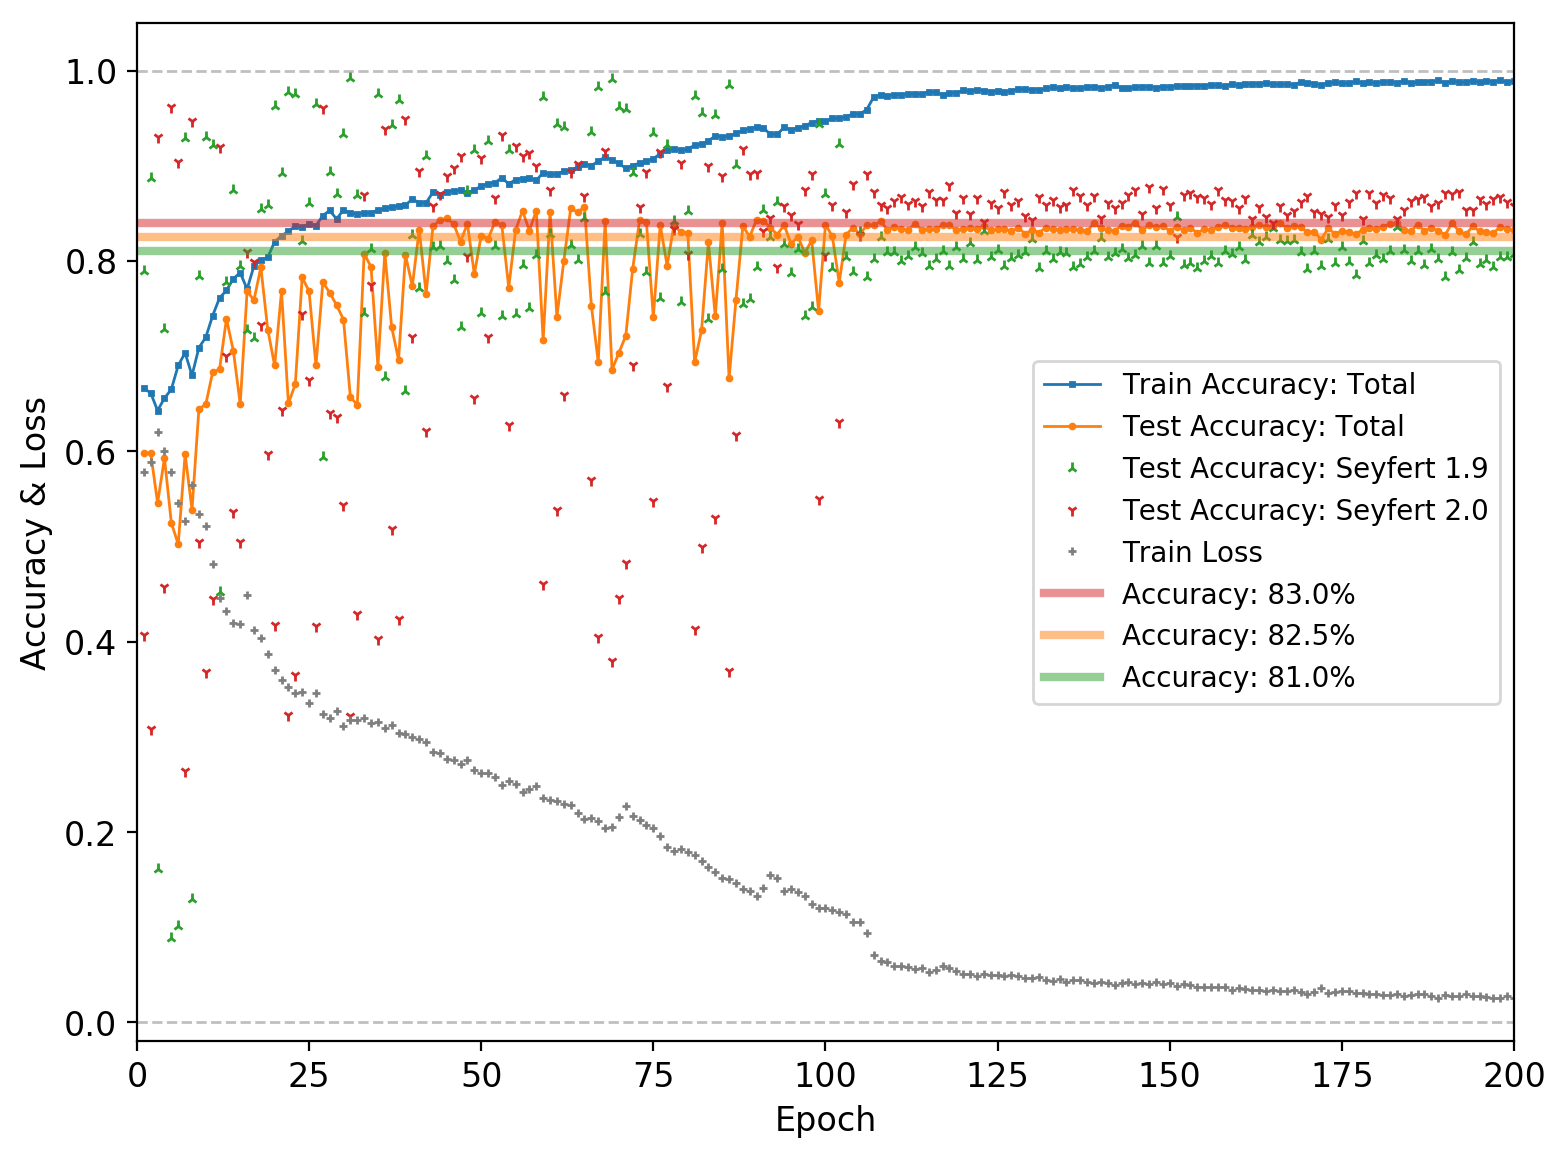

In [23]:
# save figure
fig = plt.figure(figsize=(8,6))
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, train_acc_list, 's-', color='C0', linewidth=1, markersize=1.2,label='Train Accuracy: Total')
plt.plot(epoches, (np.array(sy19_test_acc_list)+np.array(sy20_test_acc_list))/2, '.-',  color='C1', markersize=3.5, linewidth=1,label='Test Accuracy: Total')
plt.plot(epoches, sy19_test_acc_list, '2-', color='C2', linewidth=0,  markersize=4,label='Test Accuracy: Seyfert 1.9')
plt.plot(epoches, sy20_test_acc_list, '1-', color='C3', linewidth=0,  markersize=4,label='Test Accuracy: Seyfert 2.0')
plt.plot(epoches, loss_list,'+-', color='C7', linewidth=0,  markersize=3,label='Train Loss')


plt.axhline(y=1.0,color='grey',linestyle='dashed',linewidth=1, alpha=0.5, label='')
plt.axhline(y=0.84,color='C3',linestyle='solid',linewidth=3,  alpha=0.5,label='Accuracy: 83.0%')
plt.axhline(y=0.825,color='C1',linestyle='solid',linewidth=3,  alpha=0.5,label='Accuracy: 82.5%')
plt.axhline(y=0.81,color='C2',linestyle='solid',linewidth=3,  alpha=0.5,label='Accuracy: 81.0%')
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=1,  alpha=0.5, label='')

plt.legend(fontsize=10)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuracy & Loss',fontsize=12)

plt.xlim(0,200)
plt.ylim(-0.02,1.05)

figure_filename = './runs/'+'model-cuda3-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pdf'
fig.tight_layout()
plt.savefig(figure_filename, format='pdf')

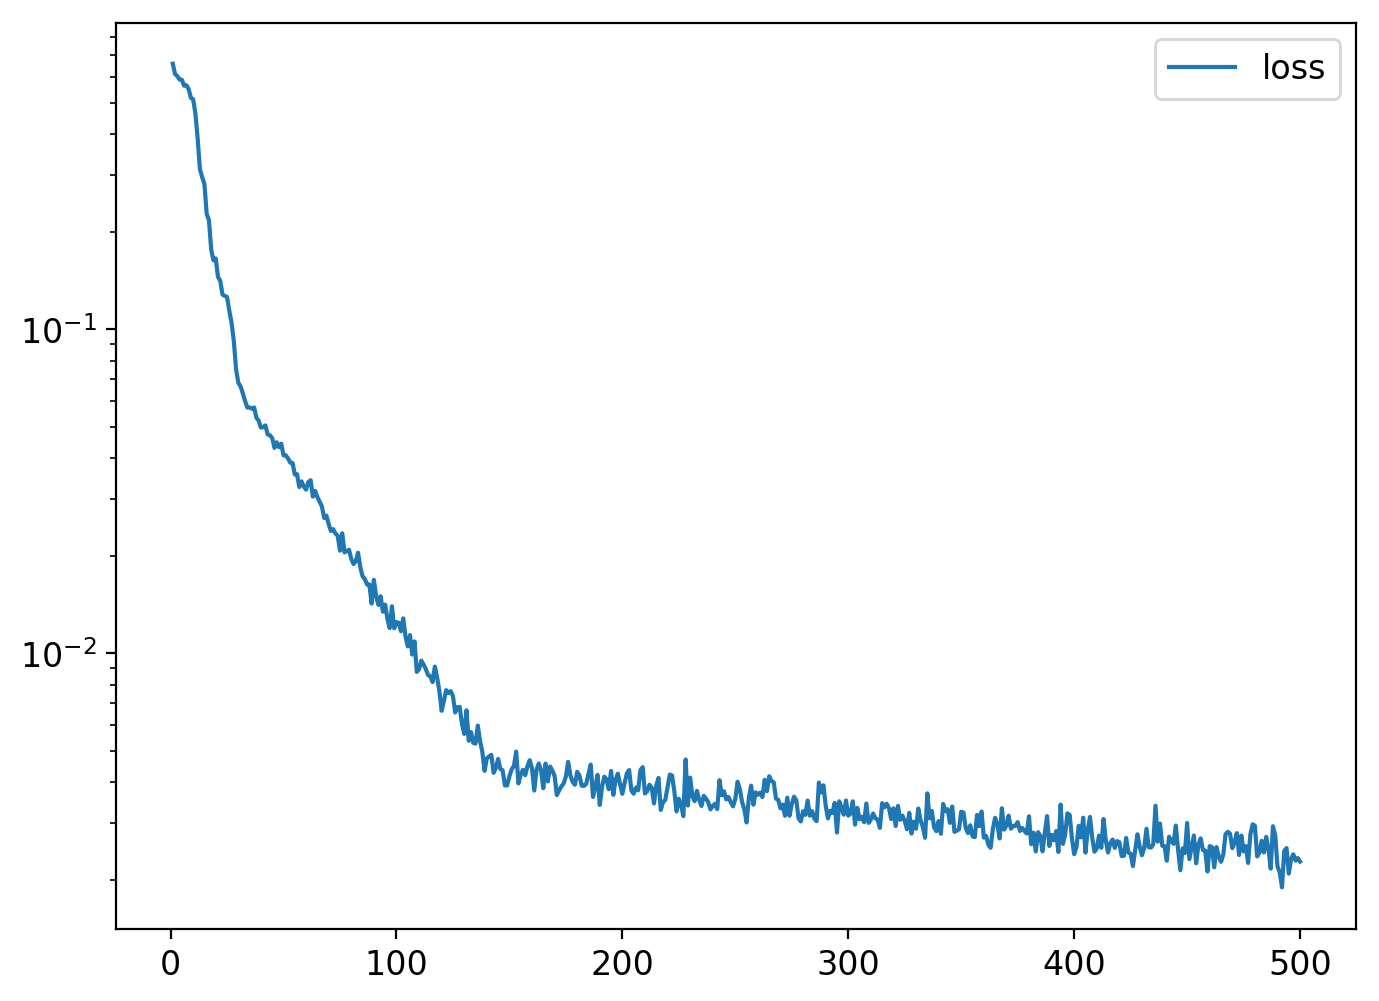

In [27]:
plt.semilogy(epoches, loss_list,label='loss')
plt.legend()